In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

In [ ]:
# Load the cleaned Walmart sales dataset from the specified path.
# This dataset is already merged, cleaned, and ready for modeling.

df = pd.read_csv('../data/cleaned_sales.csv')

# Display the first 5 rows of the DataFrame to verify structure and contents.
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Year,Month,Day,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.0,211.096358,8.106,0,A,151315,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.0,211.242170,8.106,1,A,151315,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,0.0,211.289143,8.106,0,A,151315,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,0.0,211.319643,8.106,0,A,151315,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,0.0,211.350143,8.106,0,A,151315,2010,3,5,9


In [ ]:
# Initialize a LabelEncoder to convert categorical variables into numeric form.

le = LabelEncoder()

# Define the list of categorical columns to encode.
# These include store and department IDs, holiday indicator, and store type.
categorical_cols = ['Store', 'Dept', 'IsHoliday_x', 'Type']

# Apply label encoding to each categorical column.
# This transforms string or boolean categories into integer labels.
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
    
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Year,Month,Day,Week
0,0,0,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,0.0,211.096358,8.106,0,0,151315,2010,2,5,5
1,0,0,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,...,0.0,211.242170,8.106,1,0,151315,2010,2,12,6
2,0,0,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,...,0.0,211.289143,8.106,0,0,151315,2010,2,19,7
3,0,0,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,...,0.0,211.319643,8.106,0,0,151315,2010,2,26,8
4,0,0,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,...,0.0,211.350143,8.106,0,0,151315,2010,3,5,9


In [ ]:
# Define the initial list of features to be used for model training.
# These include store info, date breakdowns, and basic context variables

features= [
    "Store", "Dept", "Type", "Size",
    "Temperature", "Fuel_Price", "IsHoliday_x",
    "Year", "Month", "Week"
]

# Identify all promotional markdown columns by filtering column names that contain "MarkDown".
markdown_cols = [col for col in df.columns if 'MarkDown' in col]

# Fill missing values in markdown columns with 0.
# Assumes missing values indicate no promotion for that week.
df[markdown_cols] = df[markdown_cols].fillna(0)

# Add the markdown columns to the features list.
features.extend(markdown_cols)

# Define the input features (X) for the model.
x = df[features]

# Define the target variable (y), applying a log1p transform to stabilize variance and handle skew.
# log1p is used instead of log to safely handle 0 values.
y=np.log1p(df["Weekly_Sales"])

c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [70]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Combine X_train and y_train into one DataFrame
train_df = x_train.copy()
train_df["Weekly_Sales"] = y_train

# Replace inf/-inf with NaN
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where the target is NaN or inf
train_df.dropna(subset=["Weekly_Sales"], inplace=True)

# Re-split clean features and target
x_train = train_df.drop("Weekly_Sales", axis=1)
y_train = train_df["Weekly_Sales"]
# Combine X_test and y_test
test_df = x_test.copy()
test_df["Weekly_Sales"] = y_test

# Replace inf/-inf with NaN and drop invalid rows
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(subset=["Weekly_Sales"], inplace=True)

# Re-split clean test set
x_test = test_df.drop("Weekly_Sales", axis=1)
y_test = test_df["Weekly_Sales"]



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid for RandomizedSearchCV.
# These ranges allow the optimizer to explore different combinations of tree depth,
# number of trees, learning rates, and sampling strategies
paramm_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize a base XGBoost regressor.
xgb_base = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV to find the best hyperparameters.
# - n_iter=20 means it will randomly try 20 combinations.
# - scoring uses negative MSE since sklearn minimizes by default.
# - cv=3 means 3-fold cross-validation.
# - n_jobs=-1 enables parallel computation on all CPU cores.
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=paramm_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search to the training data.
random_search.fit(x_train, y_train)

# Extract the best model from the searc
best_model = random_search.best_estimator_

print("Best parameters found: ", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [ ]:

# Initialize the final XGBoost regressor using the best hyperparameters
# found from RandomizedSearchCV.
model = XGBRegressor(
    n_estimators=300,
     learning_rate=0.2,
      max_depth=10,
       random_state=42,
        subsample=1.0,
         colsample_bytree=0.8
         )

# Fit the model to the training data.
# The model learns the relationship between the features and the target variable.
model.fit(x_train, y_train)

# Generate predictions on the test set (in log scale since training target was log1p-transformed).
y_pred_log = model.predict(x_test)

# Reverse the log1p transformation to return predictions to the original scale
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Reverse the log1p transformation to return predictions to the original scale
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 3212.35
MAE: 1406.04


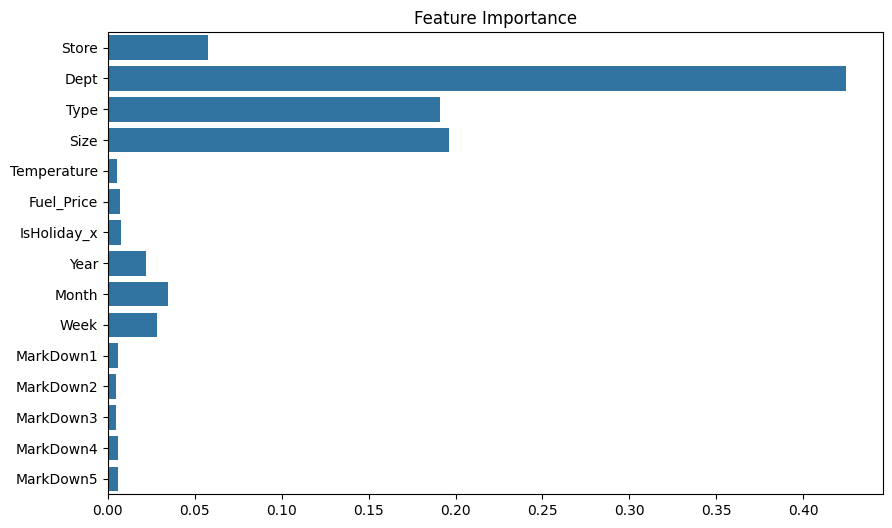

In [ ]:
#Plotting the feature importance
# This visualizes which features are most influential in the model's predictions.

plt.figure(figsize=(10,6))
importance = model.feature_importances_
sns.barplot(x=importance, y=features)
plt.title('Feature Importance')
plt.show()

In [ ]:
#Save the model to a file for later use.
# This allows for easy loading and inference without needing to retrain the model.
joblib.dump(model, '../models/xgboost_sales_model.pkl')

['../models/xgboost_sales_model.pkl']

In [ ]:

# Calculate R² score to evaluate the model's performance.
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9802
